In [1]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import csv
import keras.backend as K
from keras.layers.core import Lambda
import tensorflow as tf
import keras
import cv2

In [2]:
def load_y_data(inputPath='Personality.xlsx'):
    #return nparray: list['Neuroticism (t score)','Extraversion',
    #     'Openness','Agreeableness','Conscienciousness']*'num of people'
    print('[INFO] loading Personality Data, Path: '+ inputPath)
    personality_in1 = pd.read_excel(inputPath)
    personality = personality_in1.drop([0])
    list_personality = personality[['Neuroticism (t score)','Extraversion (t score)',\
             'Openness (t score)','Agreeableness (t score)','Conscienciousness (t score)']].values.tolist()
    nparray_personality = np.array(list_personality)
    return nparray_personality

def load_x_data(inputPath):
    print('[INFO] loading Acc Data, Path: '+ inputPath)
    x_data = []
    for u in range(2,53):
        acc = pd.read_csv(os.path.join(inputPath,f'{u}','ACC.csv'))
        #acc[0:1]はHzを表しているので除く
        x_data += [acc[1:]]
    #返り値：list、中がDataFrame
    return x_data

def split_data(data, size):
    return_list = []
    block_num = len(data) // size
    for k in range(0,block_num):
        return_list += [np.array(data[k*size:(k+1)*size])]
    #返り値：nparray
    return np.array(return_list)

def mk_data(x, y, size = 10000, number = 3, lock = 1):
    #x,y -> load_x_data,load_y_data
    xlist = []
    ylist = []
    for k in range(0,len(x)):
        if len(x[k]) < size * number:
            print('ValueError: x[k] must be more than size*number')
            break
        splited = split_data(x[k], size)
        index = list(itertools.permutations(range(splited.shape[0]), number))
        random.shuffle(index)
        upper = lock
        #print(upper)
        for l in index[:upper]:
            onedata = splited[list(l)]
            xlist += [onedata.reshape(size*number,3)]
            ylist += [y[k]]
    re_x = np.array(xlist)
    re_y = np.array(ylist)
    return re_x, re_y

def data_shuffle(x_b, y_b):
    x_list = []
#    index = np.random.permutation(len(x_b))
    index =[29,43,7,24,26,40,12,47,20,16,49,14,41,15,48,10,19,42,13,1,6,8,4,25,23,35,34,2,21,0,31,46,32,30,18,17,45,36,37,50,11,3,38,9,5,39,44,33,22,28,27]
    for i in index:
        x_list += [x_b[i]]
    y_b = y_b[index]
    return x_list, y_b, index

In [3]:
covlist = []
error = []
traindata_size = 100000

personality = load_y_data('../Personality.xlsx')

# t-scoreを０−１に落とす、平均０.５
max_values = (np.abs(personality[:, 0] - 50)).max()
y_train_before = (personality[:, 0] - 50)/(2*max_values) + 0.5

x_train_before = load_x_data('../E4wristband')

print(y_train_before.shape)


[INFO] loading Personality Data, Path: ../Personality.xlsx
[INFO] loading Acc Data, Path: ../E4wristband
(51,)


In [4]:
#user 51,44,42,41,34,28,9の削除がしたい
#del x_train_before[49]
#del x_train_before[42]
#del x_train_before[40]
#del x_train_before[39]
#del x_train_before[32]
#del x_train_before[26]
#del x_train_before[7]
#y_train_before = np.delete(y_train_before, [49,42,40,39,32,26,7], 0)

In [20]:

x_train_before, y_train_before, shuffle_index = data_shuffle(x_train_before, y_train_before)


In [21]:

# print(len(x_train_before))
split_use_num = 5
split = int(traindata_size/split_use_num)
if traindata_size%split_use_num != 0:
    print('split_use_num was individabl')
x_train,y_train = mk_data(x_train_before[:30], y_train_before[:30], split, split_use_num, 30)
x_test, y_test = mk_data(x_train_before[30:], y_train_before[30:], traindata_size, 1, 1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 100000, 3)
(900,)
(21, 100000, 3)
(21,)


In [22]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 8, padding="same", input_shape = (x_train.shape[1], 3), activation = 'relu'))
model.add(Conv1D(32, 4, padding="same", activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 2, padding="same", activation='relu'))
model.add(Conv1D(64, 2, padding="same", activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 2, padding="same", activation='relu'))
model.add(Conv1D(128, 2, padding="same", activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd', loss='mse')

model.summary()
learning = model.fit(x_train, y_train, epochs=100, validation_data = (x_test,y_test))
#Conv1Dを２層にする、
#Conv filters ->上位に行くにつれてふやす
#CNN stride

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 100000, 32)        800       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 100000, 32)        4128      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 33333, 32)         0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 33333, 64)         4160      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 33333, 64)         8256      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 11111, 64)         0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 11111, 128)       

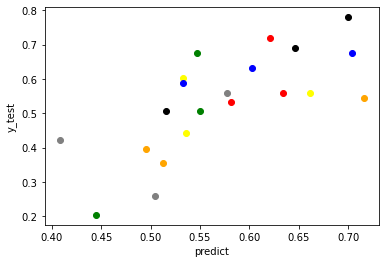

0.7106053108683217


In [23]:
result = model.predict(x_test).flatten()
plt.scatter(result[:3], y_test[:3], c ='red')
plt.scatter(result[3:6], y_test[3:6], c='yellow')
plt.scatter(result[6:9], y_test[6:9], c='blue')
plt.scatter(result[9:12], y_test[9:12], c='green')
plt.scatter(result[12:15], y_test[12:15], c='black')
plt.scatter(result[15:18], y_test[15:18], c='orange')
plt.scatter(result[18:], y_test[18:], c='grey')

plt.xlabel('predict')
plt.ylabel('y_test')
plt.show()
cov = np.corrcoef(result, y_test)
print(cov[0][1])
covlist += [cov[0][1]]

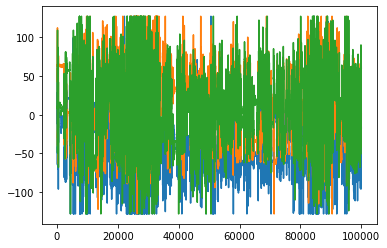

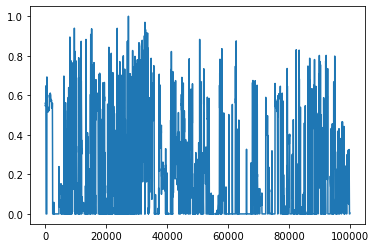

In [25]:

def target_category_loss(x, category_index, nb_classes):
    error_loss = tf.subtract(x, nb_classes)
    return tf.square(error_loss)

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def grad_cam(input_model, value, real_value,layer_name):
    
    target_layer = lambda x: target_category_loss(x, value, real_value)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    
    g = tf.Graph()
    with g.as_default():
        grads = tf.gradients(loss, conv_output)[0]
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    #output.shape=(1,*,128)
    output, grads_val = gradient_function([value])
    output, grads_val = output[0, :, :], grads_val[0, :, :]
    #output.shape=(*,128)
    weights = np.mean(grads_val, axis = 0)
    cam = np.zeros(output.shape[0], dtype = np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:, i]
        
    cam = cam.reshape([cam.shape[0], 1])
    
    cam = cv2.resize(cam, (1,traindata_size))
    cam = np.maximum(cam, 0)
    
    heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam))
    heatmap = heatmap.reshape([cam.shape[0]])
    
    return heatmap
NNN=0
predict_data = np.array([x_test[NNN]])
predictions = model.predict(predict_data)
heatmap = grad_cam(model, predict_data, y_test[NNN], 'conv1d_41')

plt.plot(x_test[NNN])
plt.show()
plt.plot(heatmap)
plt.show()

In [27]:


model.save('my_model.h5')
model.save_weights('my_model_weights.h5')

np.savez('my_model_data', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [7]:
from keras.models import load_model
npz_kw = np.load('../my_model_data.npz')
print(npz_kw.files)

model_test = load_model('../my_model.h5')
result_test = model_test.predict(npz_kw['x_test']).flatten()
print(result_test)
plt.scatter(result_test, npz_kw['x_test'])]
cov = np.corrcoef(result_test, npz_kw['y_test'])
print(cov[0][1])

SyntaxError: invalid syntax (<ipython-input-7-3df79ff171eb>, line 8)

In [89]:

for k in range(21):
    error += [[shuffle_index[30+k], result[k],result[k]-y_test[k]]]

#print(error)
print('試行回数' + str(len(error)/21))

試行回数1.0


In [90]:
def ave_error(error, total = 51):
    count = np.zeros(total)
    sum_e = np.zeros(total)
    for [num, value, er] in error:
        count[num] += 1
        sum_e[num] += abs(er)
    for k in range(total):
        if count[k] != 0:
            count[k] = sum_e[k] / count[k]
            
    return count,sum_e

ave, sum_e = ave_error(error)
print(ave)
storage = error[:]
#print(y_train_before)

[0.13647889 0.10148973 0.12842931 0.         0.34517165 0.
 0.         0.         0.         0.         0.         0.13385295
 0.         0.27798132 0.16674685 0.14411385 0.         0.
 0.         0.         0.         0.03191141 0.         0.18078293
 0.         0.         0.         0.         0.42340406 0.
 0.183803   0.         0.         0.         0.00052769 0.2007418
 0.         0.         0.11245125 0.02787125 0.         0.14719401
 0.         0.20833071 0.         0.         0.         0.16452547
 0.         0.05251    0.14830109]


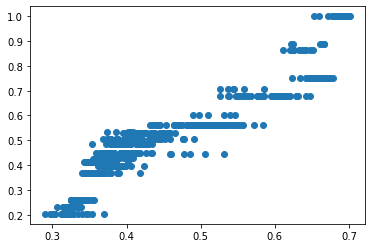

[[1.         0.93916516]
 [0.93916516 1.        ]]


In [26]:

tresult = model.predict(x_train).flatten()
plt.scatter(tresult, y_train)
plt.show()
print(np.corrcoef(tresult, y_train))

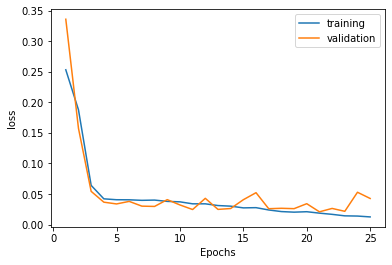

In [28]:
plt.plot(range(1, 25+1), learning.history['loss'], label="training")
plt.plot(range(1, 25+1), learning.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
np.savetxt('data/average.csv', ave, delimiter=",")
print(type(covlist[0]))
    
with open('data/cov.csv', 'w') as j:
    writer = csv.writer(j)
    writer.writerows(covlist)